+ **목적** : 리뷰글의 긍정/부정 예측을 위한 모델 생성
+ **진행순서**
  + 1.자료 불러오기 : Naver쇼핑 리뷰
  + 2.데이터 전처리/Set 분류
  + 3.데이터 정제/토큰화
  + 4.단어와 길이 분포 확인하기 
  + 5.정수 인코딩 : 
  + 6.패딩 : 샘플들의 길이를 동일하게 맞춰주는 작업
  + 7.모델링 : 1D-CNN
  + 8.모델링 : biLSTM
  + 9.결과평가

In [1]:
# Colab에 Mecab 설치
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab
# !bash install_mecab-ko_on_colab190912.sh

In [ ]:
# PyKoSpacing 설치
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
# from konlpy.tag import Mecab
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


### 1.자료 불러오기 : 라이브 커머스 방송뎃글

In [3]:
# 필요한 자료 다운로드
# urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

In [5]:
# data2 불러오기
total_data = pd.read_excel('./201103_train_data_LIVECOMM.xlsx','Sheet1')
total_data = total_data[['REVIEW', 'REVIEW_CAT2']]
total_data.rename(columns = {'REVIEW' : 'reviews', 'REVIEW_CAT2' : 'label'}, inplace = True)
print('전체 리뷰 개수(자세제품) :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수(자세제품) : 5787


In [ ]:
# total_data2['reviews'] = total_data2['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
# total_data2['reviews'] = total_data2['reviews'].replace("\n", " ")

In [ ]:
total_data

In [ ]:
# %%time

# from hanspell import spell_checker

# total_data2['reviews_adj'] = ''

# # len(total_data2)
# for i in range(0, len(total_data2)):
#     spelled_sent = spelled_sent = spell_checker.check(total_data2['reviews'][i])
#     total_data2['reviews_adj'][i] = spelled_sent.checked

### 2.데이터 전처리/Set 분류

In [6]:
# 긍종/부정으로 나누기
# total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)

# 중복 제거
total_data['label'].nunique()
total_data.drop_duplicates(subset=['reviews'], inplace=True) 

In [7]:
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 5103


In [8]:
# train_data['label'].value_counts().plot(kind = 'bar')
# plt.show()

In [9]:
# train/test Set 분류
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 3827
테스트용 리뷰의 개수 : 1276


### 3.데이터 정제/토큰화

In [10]:
# 정규 표현식 수행 : train
train_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
# train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행

# Null 값 제거 : train
train_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
train_data = train_data.dropna(how='any') # Null 값 제거

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [11]:

# 정규 표현식 수행 : test
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
# test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행

# Null 값 제거 : test
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
print('전처리 후 훈련 샘플의 개수 :',len(train_data))
print('전처리 후 테스트 샘플의 개수 :',len(test_data))

전처리 후 훈련 샘플의 개수 : 3827
전처리 후 테스트 샘플의 개수 : 1276


In [13]:
%%time

okt = Okt()

# token화
# mecab = Mecab()
# print(okt.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '요', '로', '하고', '으로']

# token화 : train
train_data['tokenized'] = train_data['reviews'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

# token화 : test
test_data['tokenized'] = test_data['reviews'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

C:\ProgramData\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


Wall time: 12 s


### 4.단어와 길이 분포 확인하기 

In [14]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [15]:
negative_word_count = Counter(negative_words)
positive_word_count = Counter(positive_words)

print(negative_word_count.most_common(20))
print('')
print(positive_word_count.most_common(10))

[('두유', 308), ('맛', 211), ('?', 177), ('좋네요', 174), ('초코', 165), ('썬', 127), ('대박', 124), ('가격', 122), ('업', 111), ('너무', 102), ('매', 101), ('매일', 97), ('일', 92), ('맛있어요', 82), ('품절', 79), ('혜택', 78), ('~', 75), ('진짜', 64), ('.', 61), ('구성', 60)]

[('구매', 261), ('두유', 219), ('했어요', 134), ('완료', 124), ('매', 116), ('박스', 115), ('썬', 111), ('~', 97), ('업', 97), ('일', 92)]


In [16]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [17]:
# negative_word_count.most_common(20)

### 5.정수 인코딩 

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 3692
등장 빈도가 1번 이하인 희귀 단어의 수: 2243
단어 집합에서 희귀 단어의 비율: 60.75297941495125
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 12.594048287478946


In [19]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1451


In [20]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### 6.패딩 : 샘플들의 길이를 동일하게 맞춰주는 작업

리뷰의 최대 길이 : 30
리뷰의 평균 길이 : 4.653775803501437


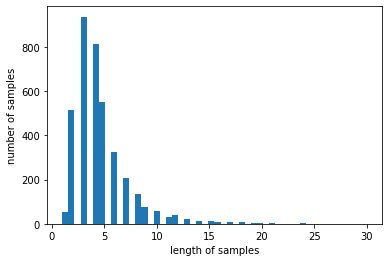

In [21]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [22]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [23]:
max_len = 20
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 20 이하인 샘플의 비율: 99.79095897569898


In [24]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### 7.모델링 : 1D CNN
 + Activation : sigmoid
 + Optimizer : RMSprop
 + Metrics : binary_crossentropy

In [25]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [26]:
model = Sequential()
model.add(Embedding(vocab_size, 20))
model.add(GRU(64))
model.add(Dense(1, activation='relu'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          29020     
_________________________________________________________________
gru (GRU)                    (None, 64)                16512     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 45,597
Trainable params: 45,597
Non-trainable params: 0
_________________________________________________________________


In [28]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('201103_model_1DCNN.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [29]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
52/52 [==============================] - ETA: 0s - loss: 0.8906 - acc: 0.5802
Epoch 00001: val_acc improved from -inf to 0.57311, saving model to 201103_model_1DCNN.h5
52/52 [==============================] - 1s 20ms/step - loss: 0.8906 - acc: 0.5802 - val_loss: 0.6378 - val_acc: 0.5731
Epoch 2/15
51/52 [============================>.] - ETA: 0s - loss: 0.5548 - acc: 0.7686
Epoch 00002: val_acc improved from 0.57311 to 0.79504, saving model to 201103_model_1DCNN.h5
52/52 [==============================] - 1s 14ms/step - loss: 0.5547 - acc: 0.7687 - val_loss: 0.5037 - val_acc: 0.7950
Epoch 3/15
49/52 [===========================>..] - ETA: 0s - loss: 0.3672 - acc: 0.8704
Epoch 00003: val_acc improved from 0.79504 to 0.82637, saving model to 201103_model_1DCNN.h5
52/52 [==============================] - 1s 13ms/step - loss: 0.3654 - acc: 0.8713 - val_loss: 0.5688 - val_acc: 0.8264
Epoch 4/15
51/52 [============================>.] - ETA: 0s - loss: 0.3395 - acc: 0.8696
Epoch 00

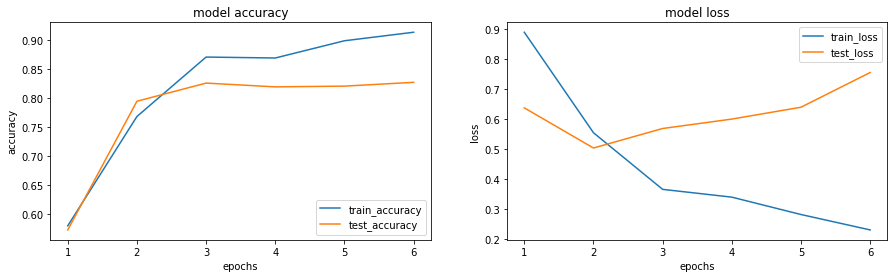

In [30]:
# 5. model evalustion : v1
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train_accuracy', 'test_accuracy'], loc='lower right')

plt.subplot(1,2,2)
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'test_loss'], loc='upper right')
plt.show()

In [ ]:
# history.save('best_model_1DCNN.h5')

### 8.모델링 : biLSTM

In [60]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [61]:
import graphviz 

In [62]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [75]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(100)))
# model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='relu'))

In [76]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         145100    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 306,101
Trainable params: 306,101
Non-trainable params: 0
_________________________________________________________________


In [77]:
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=100)

In [78]:
# plot_model(model)

In [84]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=10, patience=40)
mc = ModelCheckpoint('201103_model_biLSTM.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [85]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model2_hist = model.fit(X_train, y_train, epochs=150, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/150
12/12 [==============================] - ETA: 0s - loss: 0.1389 - acc: 0.9530- ETA: 0s - loss: 0.1408 - acc:
Epoch 00001: val_acc improved from -inf to 0.86292, saving model to 201103_model_biLSTM.h5
12/12 [==============================] - 4s 292ms/step - loss: 0.1389 - acc: 0.9530 - val_loss: 0.7854 - val_acc: 0.8629
Epoch 2/150
12/12 [==============================] - ETA: 0s - loss: 0.1314 - acc: 0.9585
Epoch 00002: val_acc did not improve from 0.86292
12/12 [==============================] - 2s 202ms/step - loss: 0.1314 - acc: 0.9585 - val_loss: 0.7995 - val_acc: 0.8629
Epoch 3/150
12/12 [==============================] - ETA: 0s - loss: 0.1205 - acc: 0.9592
Epoch 00003: val_acc did not improve from 0.86292
12/12 [==============================] - 2s 205ms/step - loss: 0.1205 - acc: 0.9592 - val_loss: 0.8689 - val_acc: 0.8551
Epoch 4/150
12/12 [==============================] - ETA: 0s - loss: 0.1159 - acc: 0.9618
Epoch 00004: val_acc did not improve from 0.86292
12/12

Epoch 32/150
12/12 [==============================] - ETA: 0s - loss: 0.0735 - acc: 0.9801
Epoch 00032: val_acc did not improve from 0.86423
12/12 [==============================] - 3s 236ms/step - loss: 0.0735 - acc: 0.9801 - val_loss: 1.6009 - val_acc: 0.8512
Epoch 33/150
12/12 [==============================] - ETA: 0s - loss: 0.0726 - acc: 0.9804
Epoch 00033: val_acc did not improve from 0.86423
12/12 [==============================] - 3s 235ms/step - loss: 0.0726 - acc: 0.9804 - val_loss: 1.6035 - val_acc: 0.8486
Epoch 34/150
12/12 [==============================] - ETA: 0s - loss: 0.0719 - acc: 0.9804
Epoch 00034: val_acc did not improve from 0.86423
12/12 [==============================] - 3s 240ms/step - loss: 0.0719 - acc: 0.9804 - val_loss: 1.6246 - val_acc: 0.8512
Epoch 35/150
12/12 [==============================] - ETA: 0s - loss: 0.0713 - acc: 0.9820
Epoch 00035: val_acc did not improve from 0.86423
12/12 [==============================] - 3s 255ms/step - loss: 0.0713 - a

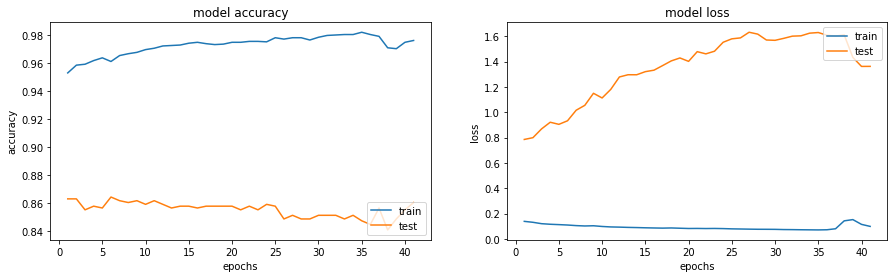

In [86]:
# 5. model evalustion : v1
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
epochs = range(1, len(model2_hist.history['acc']) + 1)
plt.plot(epochs, model2_hist.history['acc'])
plt.plot(epochs, model2_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(1,2,2)
epochs = range(1, len(model2_hist.history['loss']) + 1)
plt.plot(epochs, model2_hist.history['loss'])
plt.plot(epochs, model2_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### 8.모델링 : biLSTM

In [25]:
import tensorflow_hub as hub

In [26]:
# import tensorflow_hub as hub
import tensorflow as tf
from keras import backend as K
import urllib.request
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [27]:
from keras.models import Model
from keras.layers import Dense, Lambda, Input

input_text = Input(shape=(1,), dtype=tf.string)
embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
hidden_layer = Dense(256, activation='relu')(embedding_layer)
output_layer = Dense(1, activation='sigmoid')(hidden_layer)
model = Model(inputs=[input_text], outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

RuntimeError: It looks like you are trying to use a version of multi-backend Keras that does not support TensorFlow 2.0. We recommend using `tf.keras`, or alternatively, downgrading to TensorFlow 1.14.

In [28]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

NameError: name 'Sequential' is not defined

### 9.결과평가

In [35]:
# test
test_sentense = '늘주문하는거라 잘먹는데요\n오늘도착예정이라는 말도없이 도착했다는말도없이 문앞에 두고가셨네요\n이건 냉장제품인데 아무리 아이스박스에 담아뒀다해도 냉매 다녹았던데 왜 연락이없으신건지 이러다 상하면 애기. 어찌먹이나요\n제가 아기재우고 10시반에나가니 문앞에 있는거보고 좀어이없어서'
test_sentense = test_sentense.replace("\n", " ")

loaded_model = load_model('201019_model_1DCNN.h5')

def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.(score : {})".format(score * 100, score))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.(score : {})".format((1 - score) * 100, score))

In [36]:
# sentiment_predict(test_sentense)

98.89% 확률로 부정 리뷰입니다.(score : 0.011074423789978027)


In [69]:
i = 15500
text, scroe = total_data2['reviews'][i], total_data2['ratings'][i]
print('원문 : {}\n'.format(text))
sentiment_predict(text)

원문 : 배송 암청 빠릅니다

86.89% 확률로 긍정 리뷰입니다.(score : 0.8689199090003967)


In [51]:
score_list = [] 
for i in range(1500):
    text, scroe = total_data2['reviews'][i], total_data2['ratings'][i]
    new_sentence = okt.morphs(text) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score_list.append(float(loaded_model.predict(pad_new))) # 예측


In [68]:
total_data2['reviews'][15500]

'배송 암청 빠릅니다'

In [56]:
new_sentence

['떨어지기', '전', '구매', '하는', '상품', '임다']

In [58]:
encoded

[[2049, 150, 7, 123, 70, 6242]]

In [59]:
pad_new

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0, 2049,  150,    7,
         123,   70, 6242]])

In [52]:
# score_list

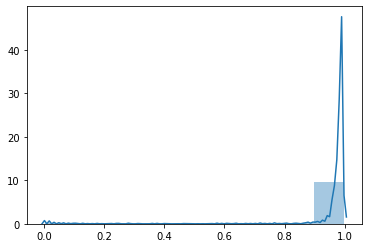

In [54]:
import seaborn as sns
sns.distplot(score_list, bins =10)
plt.show()

In [35]:
df2 = pd.read_excel('./20200923_NAVER_REVIEW_INFO.xlsx','Sheet1')

In [36]:
df2.tail()

,NAME,REVIEW,REVIEW_SCORE
431425,[매일유업] 바리스타룰스 코스타리카 330ml 12팩,연하지 않고 딱 좋네요,5
431426,[매일유업] 바리스타룰스 코스타리카 330ml 12팩,빠른 배송 감사합니다.,5
431427,[매일유업] 바리스타룰스 코스타리카 330ml 12팩,잘마시겠습니다 좋아요,4
431428,[매일유업] 바리스타룰스 코스타리카 330ml 12팩,발송 늦는다고 하셨는데 그렇게 안늦었네요,5
431429,[매일유업] 바리스타룰스 코스타리카 330ml 12팩,빠른배송 좋아요,5


In [62]:
df2['predict_biLSTM'] = 0

In [63]:
from datetime import date, time, datetime

loaded_model_biLSTM = load_model('201019_model_1DCNN.h5')
# predict_score = []

for i in range(len(df2['REVIEW'])):
    new_sentence = okt.morphs(df2['REVIEW'][i])                               # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence])                    # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len)                        # 패딩
    df2['predict_biLSTM'][i] = float(loaded_model_biLSTM.predict(pad_new))    # 예측
    if i % 1000 == 0:
        print('{} 번째 자료까지 예측 완료! (진행율 : {}% / {})'.format(i, round(i/len(df2['REVIEW'])*100,3),  str(datetime.now())) )


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


0 번째 자료까지 예측 완료! (진행율 : 0.0% / 2020-10-19 13:22:07.855222)
1000 번째 자료까지 예측 완료! (진행율 : 0.2% / 2020-10-19 13:24:59.352651)
2000 번째 자료까지 예측 완료! (진행율 : 0.5% / 2020-10-19 13:30:19.274690)
3000 번째 자료까지 예측 완료! (진행율 : 0.7000000000000001% / 2020-10-19 13:32:20.364262)
4000 번째 자료까지 예측 완료! (진행율 : 0.8999999999999999% / 2020-10-19 13:34:03.742988)
5000 번째 자료까지 예측 완료! (진행율 : 1.2% / 2020-10-19 13:40:19.855041)
6000 번째 자료까지 예측 완료! (진행율 : 1.4000000000000001% / 2020-10-19 13:42:14.231386)
7000 번째 자료까지 예측 완료! (진행율 : 1.6% / 2020-10-19 13:44:24.627130)
8000 번째 자료까지 예측 완료! (진행율 : 1.9% / 2020-10-19 13:46:15.020573)
9000 번째 자료까지 예측 완료! (진행율 : 2.1% / 2020-10-19 13:57:14.760995)
10000 번째 자료까지 예측 완료! (진행율 : 2.3% / 2020-10-19 13:59:32.061179)
11000 번째 자료까지 예측 완료! (진행율 : 2.5% / 2020-10-19 14:02:24.991931)
12000 번째 자료까지 예측 완료! (진행율 : 2.8000000000000003% / 2020-10-19 14:07:20.356814)
13000 번째 자료까지 예측 완료! (진행율 : 3.0% / 2020-10-19 14:26:55.848239)
14000 번째 자료까지 예측 완료! (진행율 : 3.2% / 2020-10-19 14:28:26.537262)
15000 번째

ResourceExhaustedError:  OOM when allocating tensor with shape[42019,100] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node sequential/embedding/embedding_lookup/Read/ReadVariableOp (defined at C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_632287]

Function call stack:
distributed_function


In [123]:
df2.to_excel('20200923_NAVER_REVIEW_INFO_v2.xlsx', sheet_name= 'Sheet1' )